In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls

drive  sample_data


In [6]:
!nvidia-smi

Tue Mar 17 01:48:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 用Keras实现神经风格迁移

In [0]:
# 定义初始变量

In [0]:
from keras.preprocessing.image import load_img, img_to_array

In [12]:
!pwd

/content


In [0]:
target_image_path = './drive/My Drive/Data/jiaju.jpg'
style_reference_image_path = './drive/My Drive/Data/portrait.jpg'

In [0]:
# 生成图像尺寸

In [0]:
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [0]:
# 辅助函数

In [0]:
import numpy as np
from keras.applications import vgg19

In [0]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [0]:
def deprocess_image(x):
    # 通过平均像素去除零中心
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # BGR转RGB
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
# 加载预训练网络VGG19，并将其应用于三张图像

In [0]:
from keras import backend as K

In [22]:
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))  # 占位符用于保存生成图像

In [0]:
# 将三张图像合并为一个批量

In [0]:
input_tensor = K.concatenate([target_image, style_reference_image, combination_image], axis=0)

In [0]:
# 以输入构建VGG19网络，加载模型将使用预训练的ImageNet

In [27]:
model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)




80142336/80134624 [==============================] - 56s 1us/step








In [37]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
# 定义损失——内容损失

In [0]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [0]:
# 定义损失——风格损失

In [0]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [0]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
# 定义损失——总变差损失

In [0]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
# 定义最小化的最终损失

In [40]:
# 将层的名称映射为激活张量的字典
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# 用于内容损失的层(较高层)
content_layer = 'block5_conv2'
# 用于风格损失的层（较低层与较高层都有）
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
# 损失分量的加权平均所使用的权重
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# 添加内容损失
loss = K.variable(0.)  # 在定义损失时，将所有分量添加到这个标量里
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features, combination_features)
# 添加风格损失
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
# 添加总变差损失
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
# 设计梯度下降过程

In [42]:
grads = K.gradients(loss, combination_image)[0]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
# 获取当前损失值和当前梯度值

In [0]:
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

In [0]:
# 将fetch_loss_and_grads包装起来，让我们可以利用两个单独的方法调用来获取损失和梯度

In [0]:
class Evaluator(object):
  def __init__(self):
    self.loss_value = None
    self.grads_values = None
  
  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value
  
  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values

In [0]:
evaluator = Evaluator()

In [0]:
# 使用SciPy的L-BFGS算法来运行梯度上升过程

In [55]:
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install Pillow

In [56]:
import scipy.misc
dir(scipy.misc)

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'absolute_import',
 'ascent',
 'central_diff_weights',
 'derivative',
 'division',
 'doccer',
 'electrocardiogram',
 'face',
 'print_function',
 'test']

In [0]:
from scipy.optimize import fmin_l_bfgs_b
from imageio import imwrite
import time

In [0]:
result_prefix = 'style_transfer_result'
iterations = 20

In [60]:
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imwrite(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 2934649300.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 11s
Start of iteration 1
Current loss value: 1081651200.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 4s
Start of iteration 2
Current loss value: 646947500.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 4s
Start of iteration 3
Current loss value: 468089630.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 4s
Start of iteration 4
Current loss value: 345139070.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 4s
Start of iteration 5
Current loss value: 269557220.0
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 4s
Start of iteration 6
Current loss value: 211806700.0
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 4s
Start of iteration 7
Current loss valu

In [0]:
from matplotlib import pyplot as plt

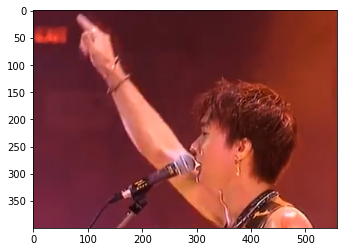

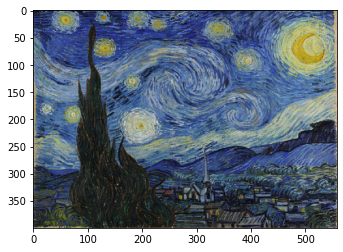

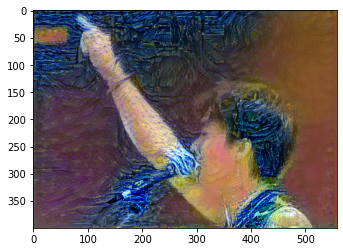

In [64]:
# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.savefig('./drive/My Drive/Data/img.jpg')
plt.show()